# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
!pip install gTTS  
#Google text to speech is a Python library and CLI tool to interface with Google Translate text-to-speech API. 

In [2]:
#Import all the required libraries

import os
import pathlib
import pickle
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage import io 
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model,activations
from keras.utils import plot_model
from wordcloud import WordCloud
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from PIL import Image
from gtts import gTTS
from IPython import display #Public API for display tools in IPython

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [3]:
#Import the dataset and read the image into a seperate variable
data = '/kaggle/input/flickr8k/'
images= os.path.join(data,'Images/')

all_imgs = glob.glob(images + '*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))
all_imgs[:2]

The total images present in the dataset: 8091


['/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg',
 '/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg']

In [4]:
df_caption = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
df_caption.head()
len(df_caption)

40455

In [5]:
#Visualise both the images & text present in the dataset
def show_image_and_its_caption(index):
    image_name, caption = df_caption.iloc[index]["image"], df_caption.iloc[index]["caption"]
    img = io.imread(pathlib.Path(images,image_name))
    plt.imshow(img)
    print(caption)

A little girl in a pink dress going into a wooden cabin .


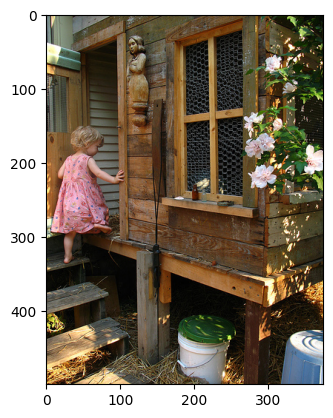

In [6]:
show_image_and_its_caption(4)

In [7]:
#Import the dataset and read the text file into a seperate variable
text_file = 'captions.txt'
def load_doc(filename):
    
    text = pd.read_csv(data + filename)
    
    return text

doc = load_doc(text_file)
print(doc[:300])

                         image  \
0    1000268201_693b08cb0e.jpg   
1    1000268201_693b08cb0e.jpg   
2    1000268201_693b08cb0e.jpg   
3    1000268201_693b08cb0e.jpg   
4    1000268201_693b08cb0e.jpg   
..                         ...   
295  1077546505_a4f6c4daa9.jpg   
296  1077546505_a4f6c4daa9.jpg   
297  1077546505_a4f6c4daa9.jpg   
298  1077546505_a4f6c4daa9.jpg   
299  1077546505_a4f6c4daa9.jpg   

                                               caption  
0    A child in a pink dress is climbing up a set o...  
1                A girl going into a wooden building .  
2     A little girl climbing into a wooden playhouse .  
3    A little girl climbing the stairs to her playh...  
4    A little girl in a pink dress going into a woo...  
..                                                 ...  
295  A boy in blue shorts slides down a slide into ...  
296  A boy in blue swimming trunks slides down a ye...  
297  A boy rides down a slide into a small backyard...  
298  A boy sliding do

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [8]:
all_img_id = df_caption['image']
all_img_vector = [data + 'Images/' + str(img) for img in all_img_id]
annotations = df_caption['caption']

In [9]:
data = {'ID': all_img_id,'Path':all_img_vector,'Captions':annotations}
df = pd.DataFrame(data=data)     
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb543...,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb543...,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb543...,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb543...,A rock climber in a red shirt .


In [10]:
#Create a list which contains all the captions
annotations= ['<start> '+ text +' <end>' for text in df.Captions]
#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path= list(df.Path)

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))
print (annotations[:2])

Total captions present in the dataset: 40455
Total images present in the dataset: 40455
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>']


In [11]:
#Create the vocabulary & the counter for the captions 
concat_str = ' '.join([str(text).strip('\n') for text in annotations]) 
#print(concat_str[:500])
vocabulary= concat_str.split(' ')
print(vocabulary[:50])
print("vocabulary length: "+ str(len(set(vocabulary))))
val_count=Counter(vocabulary)
#val_count


['<start>', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<end>', '<start>', 'A', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<end>', '<start>', 'A', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<end>', '<start>', 'A', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her']
vocabulary length: 9632


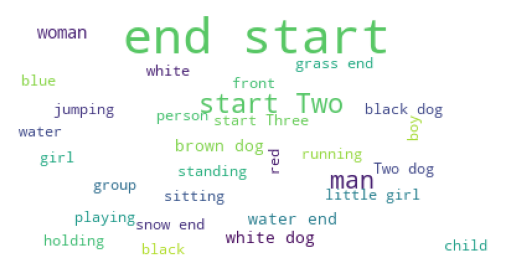

In [12]:
#Visualise the top 30 occuring words in the captions
wordcloud = WordCloud(
                          background_color='white',
                          max_words=30,
                          max_font_size=40,
                          random_state=42
                         ).generate(str(annotations))

plt.imshow(wordcloud)
plt.axis('off')
plt.show();

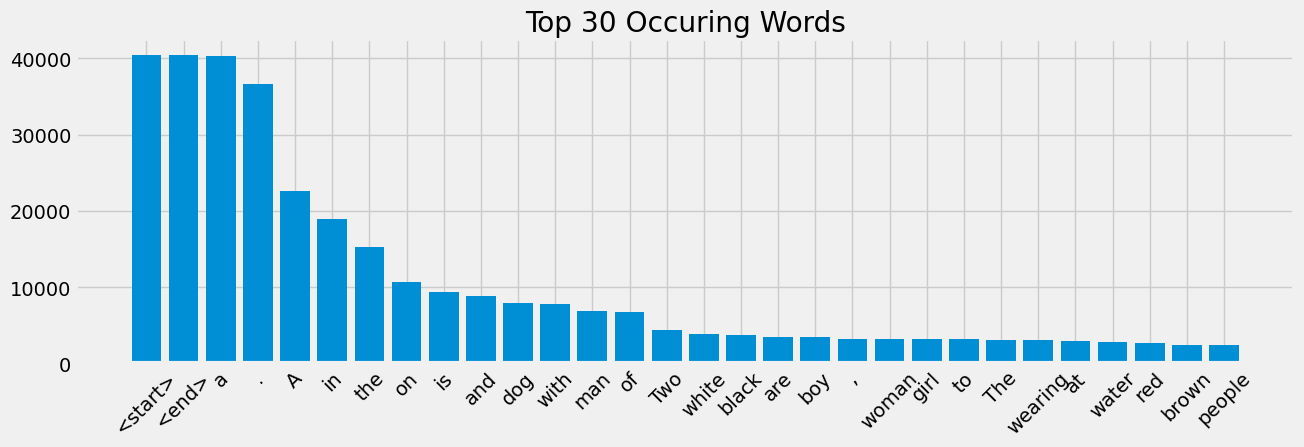

In [13]:
#Visualise the top 30 occuring words in the captions
def plot_top_words(word_counter):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(14,4))
    plt.xticks(rotation=45)
    plt.bar(*zip(*word_counter))
    plt.title("Top 30 Occuring Words")
    plt.show()

plot_top_words(val_count.most_common(30))


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [14]:
# create the tokenizer
top_word_cnt = 5000
tokenizer = Tokenizer(num_words = top_word_cnt +1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False, 
                      oov_token = 'UNK')

In [15]:
tokenizer.fit_on_texts(annotations)
#transform each text into a sequence of integers
text_seqs = tokenizer.texts_to_sequences(annotations)

In [16]:
text_seqs[:4]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4]]

In [17]:
word_index = tokenizer.word_index
index_word = tokenizer.index_word

tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [18]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [19]:
word_count_dict = dict(tokenizer.word_counts.items())
#word_count_dict

In [20]:
len(word_count_dict)

8495

In [21]:
len(tokenizer.index_word)

8497

In [22]:
## Save Tokenizer
with open('./tokenizer.pkl',"wb") as f:
    pickle.dump(tokenizer,f)

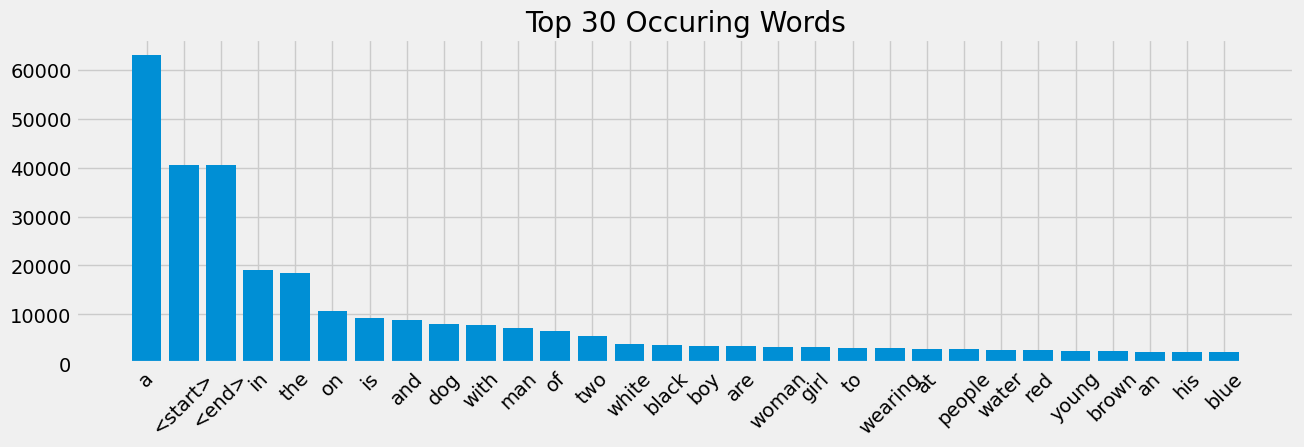

In [23]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda kv : kv[1], reverse= True)  #kv[1]: word frequency, reverse = True : desc order
plot_top_words(sort_word_by_count[:30])

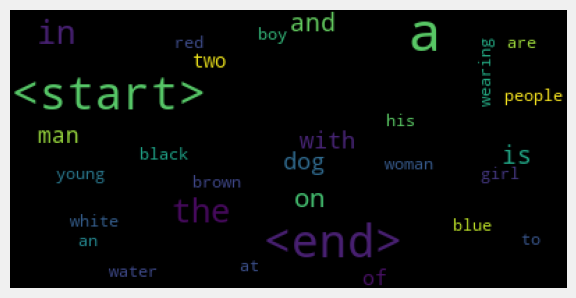

In [24]:
wordcloud = WordCloud(background_color='black',max_words=30,
                          max_font_size=40,
                          random_state=42).generate_from_frequencies(word_count_dict)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [25]:
# Pad each vector to the max_length of the captions  store it to a vairable

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(text_seqs, padding= 'post', 
                                                          dtype='int32', value=0) 
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [26]:
IMAGE_SHAPE = (299,299)

In [27]:
#write your code here for creating the function. This function should return images & their path

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = preprocess_input(img)
    return img, image_path

# Check the preprocessing Logic
print(f'Size of image before preprocessing: {io.imread(all_img_vector[0]).shape}')
print(f'Size of image after preprocessing: {preprocess_image(all_img_vector[0])[0].shape}')
    
    

Size of image before preprocessing: (500, 375, 3)
Size of image after preprocessing: (299, 299, 3)


In [28]:
len(sorted(set(all_img_vector)))

8091

In [29]:
#write your code here to create the dataset consisting of image paths
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

unique_img_paths = sorted(set(all_img_vector))
img_data = tf.data.Dataset.from_tensor_slices(unique_img_paths)
print(img_data)
img_data = img_data.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)
                
img_data

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [30]:
#list(img_data.as_numpy_iterator())

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [31]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input  #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output  #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

87910968/87910968 [==============================] - 0s 0us/step


In [32]:
#image_features_extract_model.summary()

In [33]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
fv_dict = {}
for img,path in tqdm(img_data):
    fv_out = image_features_extract_model(img)
    fv_flattened = tf.reshape(fv_out,(fv_out.shape[0],-1,fv_out.shape[3])) 
    for fv_img,path in zip(fv_flattened,path):
        path = path.numpy().decode("utf-8") #This decoding is done because the values are not in ASCII
        fv_dict[path] = fv_img.numpy()  #This will convert the tensor instance to numpy

100%|██████████| 127/127 [00:44<00:00,  2.86it/s]


In [34]:
print(fv_out.shape) # Last batch has only 27 images (126*64 + 27 = 8091)
print(fv_out[0].shape)
print(fv_flattened.shape)
print(fv_flattened[0].shape)

(27, 8, 8, 2048)
(8, 8, 2048)
(27, 64, 2048)
(64, 2048)


In [35]:
len(fv_dict)

8091

In [36]:
#view top five items of features dict
import more_itertools
top_5 = more_itertools.take(5, fv_dict.items())
top_5

[('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.16987026],
         [0.        , 0.        , 1.0105907 , ..., 0.        , 0.        ,
          0.06111786],
         ...,
         [0.        , 0.        , 2.0380435 , ..., 1.2029829 , 0.        ,
          1.9924148 ],
         [0.        , 0.        , 0.90468955, ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2527343 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.663691  , 0.46286264, ..., 0.        , 0.        ,
          3.33227   ],
         [0.        , 1.2268168 , 0.        , ..., 0.        , 0.25390095,
          3.3295412 ],
         [1.2881793 , 1.5195348 , 0.        , ..., 0.4677851 ,

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [37]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector, cap_vector, test_size = 0.2, random_state = 42)

In [38]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [39]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(img_path, cap):
    img_tensor = fv_dict[img_path.decode('utf-8')]
    return img_tensor, cap

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [40]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
# tf.numpy_function() : Wraps a python function and uses it as a TensorFlow op.

BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img_path, cap):
        
    dataset = tf.data.Dataset.from_tensor_slices((img_path, cap))
    dataset = dataset.map(lambda ele1, ele2 : tf.numpy_function(map_func, [ele1, ele2], [tf.float32, tf.int32]),num_parallel_calls = tf.data.experimental.AUTOTUNE)           
    dataset = (dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE , drop_remainder = False).prefetch(tf.data.experimental.AUTOTUNE))
    return dataset



In [41]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [42]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [43]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train)  // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

In [44]:
train_num_steps

505

In [45]:
test_num_steps

126

### Encoder

In [46]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features)# extract the features from the image shape: (batch, 8*8, embed_dim)
        features = activations.relu(features)
        return features
    
    def model(self):
        features = keras.Input(shape = (64,2048), batch_size = 64)     
        
        return Model(inputs = features, outputs = self.call(features))

In [47]:
encoder=Encoder(embedding_dim)

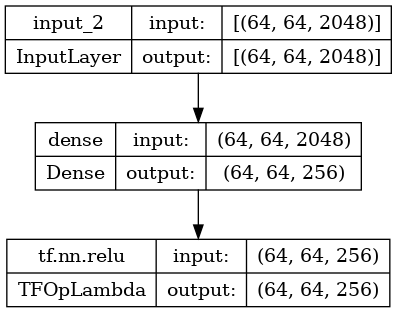

In [48]:
plot_model(encoder.model(),to_file = 'encoder.png', show_shapes = True)

In [49]:
encoder.model().summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(64, 64, 2048)]          0         
                                                                 
 dense (Dense)               (64, 64, 256)             524544    
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (64, 64, 256)             0         
                                                                 
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________


### Attention model

In [50]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =  layers.Dense(units)  #build your Dense layer for image feature vector
        self.W2 =  layers.Dense(units)   #build your Dense layer for hidden state
        self.V =   layers.Dense(1)  #build your final Dense layer with unit 1 for flattening after addition of fv and hidden state
        self.units = units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim). This is the output of Encoder.
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, axis = 1)   # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = self.V(activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))  # build your score funciton to shape: (batch_size, 8*8, 1)
        attention_weights = activations.softmax(score,axis = 1)   # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features   #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # reduce the shape to (batch_size, embedding_dim)
        
        return context_vector, attention_weights
    
    def model(self):
        features = keras.Input(shape = (64,256), batch_size = 64 ) 
        hidden = keras.Input(shape = (512), batch_size = 64)
        
        return Model(inputs = [features,hidden], outputs = self.call(features,hidden))

In [51]:
attention = Attention_model(units)

In [52]:
attention.model().summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(64, 512)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(64, 64, 256)]      0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (64, 1, 512)         0           ['input_5[0][0]']                
                                                                                                  
 dense_1 (Dense)                (64, 64, 512)        131584      ['input_4[0][0]']                
                                                                                            

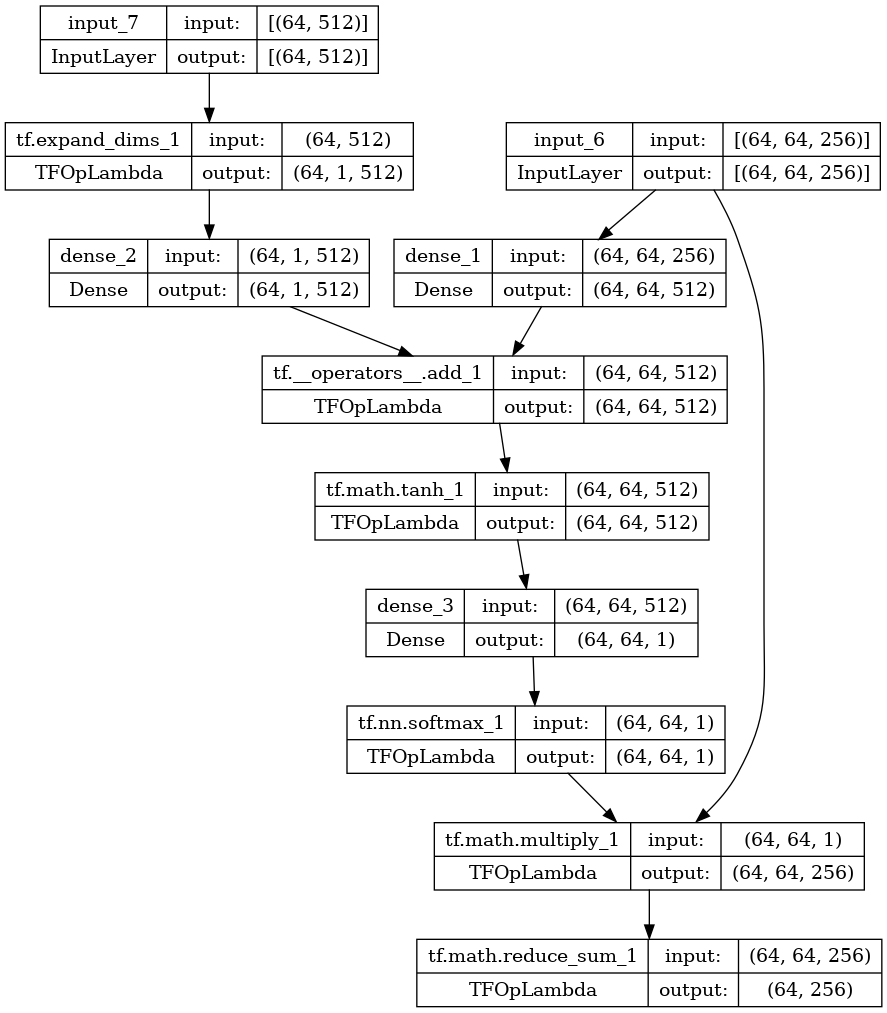

In [53]:
plot_model(attention.model(), to_file = 'attention.png',show_shapes = True)

### Decoder

In [54]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed =  layers.Embedding(input_dim = vocab_size, output_dim = embed_dim)  #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)  #build your Dense layer
        self.d2 = layers.Dense(vocab_size)  #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)  #create your context vector & attention weights from attention model
        embed =  self.embed(x)  # embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)  # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))  # Initial hidden state (shape = 512)
    
    def model(self):
        x = keras.Input(shape = (1), batch_size = 64)  # shape=1 refers to the word_index of the word at that timestamp
        features = keras.Input(shape = (64,256), batch_size = 64 ) 
        hidden = keras.Input(shape = (512), batch_size = 64)
        
        return Model(inputs = [x,features,hidden], outputs = self.call(x,features,hidden))
    
    

In [55]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [56]:
decoder.model().summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(64, 64, 256)]      0           []                               
                                                                                                  
 input_10 (InputLayer)          [(64, 512)]          0           []                               
                                                                                                  
 attention_model_1 (Attention_m  ((64, 256),         394753      ['input_9[0][0]',                
 odel)                           (64, 64, 1))                     'input_10[0][0]']               
                                                                                                  
 input_8 (InputLayer)           [(64, 1)]            0           []                         

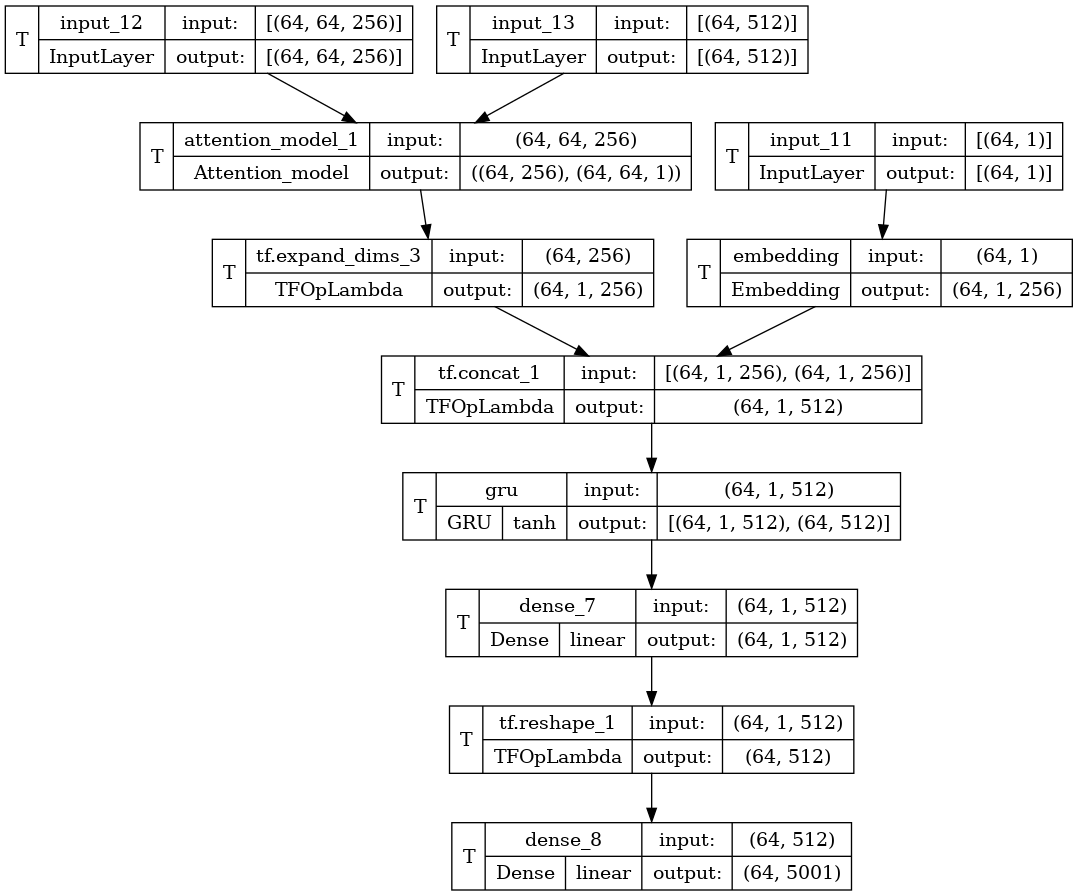

In [57]:
plot_model(decoder.model(),to_file = 'decoder.png' ,show_shapes = True,show_layer_activations=True,
    show_trainable=True, expand_nested=True)

In [58]:
#This section verifies the models build, using a sample batch

features=encoder(sample_img_batch)
hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)  # Providing 64 <start> tokens to indicate start of 64 captions

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)

print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Shape of hidden: {}'.format(hidden.shape)) 
print('Shape of dec_input: {}'.format(dec_input.shape))
print('Predictions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Shape of hidden_out from Decoder: {}'.format(hidden_out.shape))
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, 1)

Feature shape from Encoder: (64, 64, 256)
Shape of hidden: (64, 512)
Shape of dec_input: (64, 1)
Predictions shape from Decoder: (64, 5001)
Shape of hidden_out from Decoder: (64, 512)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [59]:
optimizer = keras.optimizers.Adam(lr=0.001)  
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')  #Since decoder does not have a softmax therefore, logits = True

In [60]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [61]:
!ls /kaggle/working

__notebook__.ipynb  attention.png  decoder.png	encoder.png  tokenizer.pkl


In [62]:
if not os.path.exists("/kaggle/working/checkpoints/"):
    os.mkdir("/kaggle/working/checkpoints/") 

In [63]:
checkpoint_path = "/kaggle/working/checkpoints/"
#checkpoint_path = os.path.join("checkpoints","train")
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)



In [64]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [65]:
@tf.function
def train_step(img_tensor, target):   
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions,hidden,_ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)  
            dec_input = tf.expand_dims(target[:, i], 1)  #Teacher enforcing
        avg_loss = (loss/target.shape[1])  #Avg loss over a caption
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
           
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [66]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1,target.shape[1]):
        predictions,hidden,_ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions) 
        predicted_id = tf.argmax(predictions,1)  # No Teacher enforcing
        dec_input = tf.expand_dims(predicted_id, 1)
         
    avg_loss = (loss/target.shape[1])  #Avg loss over a batch   
        
    return loss, avg_loss

In [67]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [68]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
                
        ckpt_manager.save()
      

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.292, & test loss is 1.897
Time taken for 1 epoch 183.52414178848267 sec

Test loss has been reduced from 100.000 to 1.897


  7%|▋         | 1/15 [03:03<42:53, 183.79s/it]

For epoch: 2, the train loss is 0.997, & test loss is 1.889
Time taken for 1 epoch 68.05352592468262 sec

Test loss has been reduced from 1.897 to 1.889


 13%|█▎        | 2/15 [04:12<25:05, 115.83s/it]

For epoch: 3, the train loss is 0.901, & test loss is 1.876
Time taken for 1 epoch 67.43400645256042 sec

Test loss has been reduced from 1.889 to 1.876


 27%|██▋       | 4/15 [06:26<15:16, 83.35s/it]

For epoch: 4, the train loss is 0.837, & test loss is 1.884
Time taken for 1 epoch 67.27489447593689 sec



 33%|███▎      | 5/15 [07:33<12:52, 77.20s/it]

For epoch: 5, the train loss is 0.786, & test loss is 1.950
Time taken for 1 epoch 66.30043029785156 sec



 40%|████      | 6/15 [08:39<11:02, 73.56s/it]

For epoch: 6, the train loss is 0.739, & test loss is 1.932
Time taken for 1 epoch 66.49816918373108 sec



 47%|████▋     | 7/15 [09:46<09:29, 71.19s/it]

For epoch: 7, the train loss is 0.698, & test loss is 1.969
Time taken for 1 epoch 66.30447506904602 sec



 53%|█████▎    | 8/15 [10:52<08:07, 69.64s/it]

For epoch: 8, the train loss is 0.659, & test loss is 2.034
Time taken for 1 epoch 66.31735014915466 sec



 60%|██████    | 9/15 [11:58<06:51, 68.54s/it]

For epoch: 9, the train loss is 0.623, & test loss is 2.072
Time taken for 1 epoch 66.12769722938538 sec



 67%|██████▋   | 10/15 [13:04<05:39, 67.86s/it]

For epoch: 10, the train loss is 0.589, & test loss is 2.138
Time taken for 1 epoch 66.33149099349976 sec



 73%|███████▎  | 11/15 [14:11<04:29, 67.38s/it]

For epoch: 11, the train loss is 0.558, & test loss is 2.192
Time taken for 1 epoch 66.27887916564941 sec



 80%|████████  | 12/15 [15:17<03:20, 66.98s/it]

For epoch: 12, the train loss is 0.529, & test loss is 2.270
Time taken for 1 epoch 66.06975388526917 sec



 87%|████████▋ | 13/15 [16:23<02:13, 66.77s/it]

For epoch: 13, the train loss is 0.501, & test loss is 2.335
Time taken for 1 epoch 66.288569688797 sec



 93%|█████████▎| 14/15 [17:29<01:06, 66.62s/it]

For epoch: 14, the train loss is 0.476, & test loss is 2.430
Time taken for 1 epoch 66.26350903511047 sec



100%|██████████| 15/15 [18:36<00:00, 74.42s/it]

For epoch: 15, the train loss is 0.452, & test loss is 2.520
Time taken for 1 epoch 66.47264409065247 sec



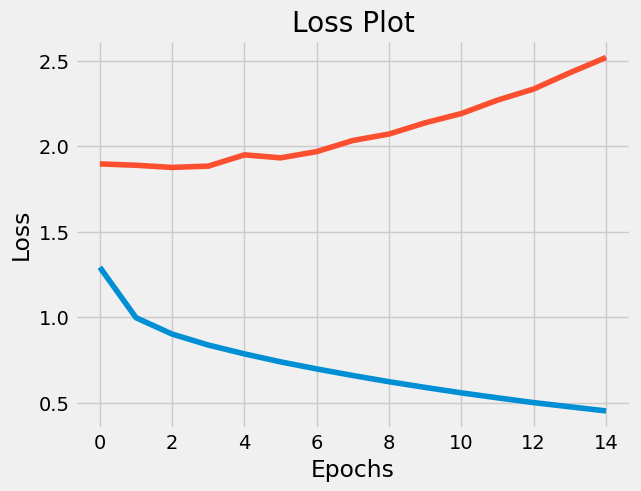

In [69]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [70]:
!ls
!cd ./checkpoints/
!ls checkpoints/

__notebook__.ipynb  checkpoints  encoder.png
attention.png	    decoder.png  tokenizer.pkl
checkpoint		    ckpt-2.data-00000-of-00001	ckpt-3.index
ckpt-1.data-00000-of-00001  ckpt-2.index
ckpt-1.index		    ckpt-3.data-00000-of-00001


In [71]:
!cat ./checkpoints/checkpoint

model_checkpoint_path: "ckpt-3"
all_model_checkpoint_paths: "ckpt-1"
all_model_checkpoint_paths: "ckpt-2"
all_model_checkpoint_paths: "ckpt-3"
all_model_checkpoint_timestamps: 1698644056.694539
all_model_checkpoint_timestamps: 1698644124.9621406
all_model_checkpoint_timestamps: 1698644192.6076074
last_preserved_timestamp: 1698643871.111159


In [72]:
print('shpe of loss_plot', loss_plot)
print('shpe of test_loss_plot', test_loss_plot)

shpe of loss_plot [<tf.Tensor: shape=(), dtype=float32, numpy=1.29226>, <tf.Tensor: shape=(), dtype=float32, numpy=0.99723923>, <tf.Tensor: shape=(), dtype=float32, numpy=0.90142155>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8373621>, <tf.Tensor: shape=(), dtype=float32, numpy=0.78553504>, <tf.Tensor: shape=(), dtype=float32, numpy=0.73897237>, <tf.Tensor: shape=(), dtype=float32, numpy=0.69763815>, <tf.Tensor: shape=(), dtype=float32, numpy=0.6590982>, <tf.Tensor: shape=(), dtype=float32, numpy=0.6226848>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5894296>, <tf.Tensor: shape=(), dtype=float32, numpy=0.55765676>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5286096>, <tf.Tensor: shape=(), dtype=float32, numpy=0.50064903>, <tf.Tensor: shape=(), dtype=float32, numpy=0.47618136>, <tf.Tensor: shape=(), dtype=float32, numpy=0.45208624>]
shpe of test_loss_plot [<tf.Tensor: shape=(), dtype=float32, numpy=1.8971436>, <tf.Tensor: shape=(), dtype=float32, numpy=1.889>, <tf.Tensor: shape=(

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [73]:
attention_features_shape = 64
max_seq_length = cap_vector.shape[1]
def evaluate(image):
    attention_plot = np.zeros((max_seq_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)  # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)  # extract the features by passing the input to encoder
    #print("shape of features", features.shape)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    #print("shape of first dec_input", dec_input.shape)
    result = []

    for i in range(max_seq_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)# get the output from decoder
        #print("shape of predictions", predictions.shape)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()  
        predicted_id = (tf.argmax(predictions,1)).numpy()[0]  #extract the predicted id(index value from tokenizer) which carries the max value
        #print("predicted_id:", predicted_id)
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])
        
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)
        
        
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

'''
Shape of features: (1,64,256)
Shape of first dec_input: (1,1)
Shape of predictions: (1,5001)
'''



'\nShape of features: (1,64,256)\nShape of first dec_input: (1,1)\nShape of predictions: (1,5001)\n'

### Beam Search(optional)

In [74]:
attention_features_shape = 64
max_seq_length = cap_vector.shape[1]
def beam_evaluate(image, beam_index = 3):

    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_seq_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_seq_length:
        temp = []
        for i, s in enumerate(result):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

a yellow dog is running in a grass


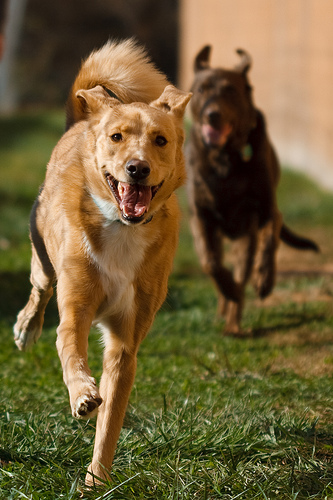

In [75]:
test_image = "/kaggle/input/flickr8k/Images/3106883334_419f3fb16f.jpg"
captions=beam_evaluate(test_image)
print(captions)
Image.open(test_image)

In [76]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [77]:
from nltk.translate.bleu_score import sentence_bleu

In [78]:
def filt_text(text):
    filt=['<start>','UNK','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [79]:
def test_caption_generation(img_test_batch):
    rid = np.random.randint(0, len(img_test_batch))
    test_image = img_test_batch[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)      


    pred_caption=' '.join(result).rsplit(' ', 1)[0]
      
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights= (0.5,0.5,0,0))  #set your weights
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)
    
    Image.open(test_image)
    
    ##Converting text to speech
    tts = gTTS(pred_caption, lang = 'en', slow = False)
    #This can be downloaded and played
    filename = '/kaggle/working/caption.mp3'
    tts.save(filename) 
    display.display(display.Audio(filename, rate = None, autoplay = False)) # To display playback bar as output
    

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BELU score: 37.74712317014531
Real Caption: two teams of soccer players playing a game on a field
Prediction Caption: a soccer player is trying to get the ball


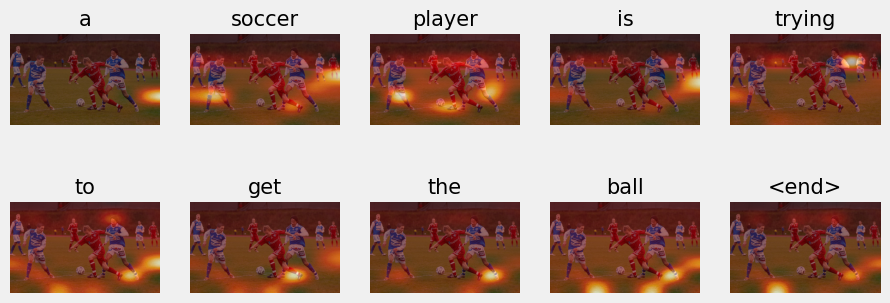

In [80]:
test_caption_generation(path_test)